## Machine Learning Modeling

This notebook intents to create machine learning models for predicting Samambaia house prices. Specifically, we're interested in regression models, and even further, stacked regressions.

This notebook uses <a target='_blank' href='https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard'>this kaggle notebook</a> as a reference.

The feature engineering processes are:
* Inputing missing values;
* Transforming numerical data that looks like categorical;
* Label enconding categorical variables;
* Transform non-normal data to normal shape (skewed data to normal distribution);
* Get dummy variables for categorial columns.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from scipy.stats import norm, skew
from scipy import stats

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

from subprocess import check_output
#check the files available in the directory

Read the train and test data.

In [2]:
train_df = pd.read_csv('./data/train.csv', index_col=[0])
test_df = pd.read_csv('./data/test.csv', index_col=[0])

Show the first rows of training data

In [3]:
train_df.head(5)

,house_price,house_region,n_bedrooms,has_condominium,value_condominium,has_garage,n_garage,house_size,house_hyperlink,house_category,n_bathrooms,zip_code,street_address,metro_distance
1649,335000.000,Sul,2,Com condomínio,0.000,Com garagem,1,50.000,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,2,72300533.000,Quadra 301 Conjunto 2,3
2761,440000.000,Norte,3,Com condomínio,0.000,Com garagem,1,119.000,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,2,72318210.000,QR 406 Conjunto 9-A,2
223,290000.000,Norte,3,Com condomínio,385.000,Com garagem,1,NaN,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,2,72318230.000,QR 406 Conjunto 28,2
106,210000.000,Norte,3,Com condomínio,0.000,Com garagem,1,112.000,https://df.olx.com.br/distrito-federal-e-regia...,Casas,3,72322505.000,QS 602 Conjunto E Comércio,3
2541,183000.000,Norte,2,Com condomínio,0.000,Com garagem,1,33.000,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,1,72321000.000,QR 407,3


Show the first rows of test data

In [4]:
test_df.head(5)

,house_price,house_region,n_bedrooms,has_condominium,value_condominium,has_garage,n_garage,house_size,house_hyperlink,house_category,n_bathrooms,zip_code,street_address,metro_distance
487,120008.000,Sul,2,Com condomínio,260.000,Com garagem,1,47.000,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,1,72302203.000,QR 108 Conjunto 3,1
2770,294900.000,Norte,2,Com condomínio,0.000,Com garagem,2,120.000,https://df.olx.com.br/distrito-federal-e-regia...,NaN,NaN,NaN,NaN,3
134,200000.000,Sul,3,Sem condomínio,0.000,Sem garagem,0,NaN,https://df.olx.com.br/distrito-federal-e-regia...,Casas,2,72301700.000,QR 115,3
1057,420000.000,Norte,4,Com condomínio,1.000,Com garagem,3,112.000,https://df.olx.com.br/distrito-federal-e-regia...,Casas,2,72318112.000,QR 404 Conjunto 11,2
454,209000.000,Sul,2,Com condomínio,0.000,Com garagem,1,42.000,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,1,72310000.000,QN 320,3


So, we have the following description for columns:
* <b>house_price</b>: the sale price;
* <b>house_region</b>: the region of the house. if house_region == Sul, it means south, else house_region == Norte means north;
* <b>n_bedrooms</b>: the number of bedrooms;
* <b>has_condominium</b>: whether there is or no condominium for the house. Com condomínio means there is condominium to pay for, Sem condomínio means there is no condominium to pay;
* <b>value_condominium</b>: the value of the condominium;
* <b>has_garage</b>: Whether there is or no garage in the house (or apartment). Com garagem means there is a garage, Sem garagem means there isn't a garage;
* <b>n_garage</b>: The number of parking spaces;
* <b>house_size</b>: the size of the property;
* <b>house_category</b>: The property category: Apartamentos means apartments and Casas means houses;
* <b>n_bathrooms</b>: The number of bathrooms;
* <b>zip_code</b>: The zip code;
* <b>street_address</b>: The street address of the house;
* <b>metro_distance</b>: The distance to the metro station.

Now, we'll delete the hyperlink feature as it won't have any use in our machine learning models:

In [5]:
# Check the number of samples and features
print(f'The train data size before dropping Hyperlink feature is {train_df.shape}')
print(f'The test data size before dropping Hyperlink feature is {test_df.shape}')

train_hyperlink = train_df['house_hyperlink']
test_hyperlink = test_df['house_hyperlink']

# Now drop the 'house_hyperlink' column since it's unnecessary for the prediction process.
train_df.drop('house_hyperlink', axis = 1, inplace = True)
test_df.drop('house_hyperlink', axis = 1, inplace = True)

# Check again the data size after droping the 'house_hyperlink' column
print(f'\nThe train data size after dropping Hyperlink feature is {train_df.shape}')
print(f'The test data size after dropping Hyperlink feature is {test_df.shape}')

The train data size before dropping Hyperlink feature is (1991, 14)
The test data size before dropping Hyperlink feature is (854, 14)

The train data size after dropping Hyperlink feature is (1991, 13)
The test data size after dropping Hyperlink feature is (854, 13)


### Data Processing

#### Outliers

We've seen in the Exploratory Data Analysis notebook that one apartment in specific had huge size and low price. Let's see the data again:

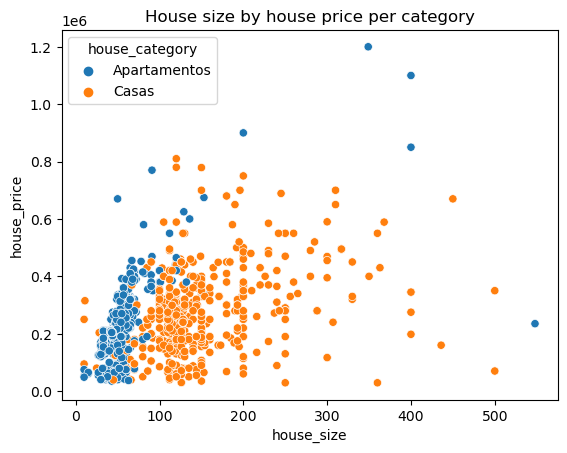

In [6]:
sns.scatterplot(
    data=train_df, 
    x = train_df['house_size'], 
    y = train_df['house_price'],
    hue=train_df['house_category'])

plt.title('House size by house price per category')
plt.show()

Apartamentos are apartments and Casas are houses, in portuguese. See we have a blue dot showing a large apartment that seems not common. We'll remove that point and make the plot again.

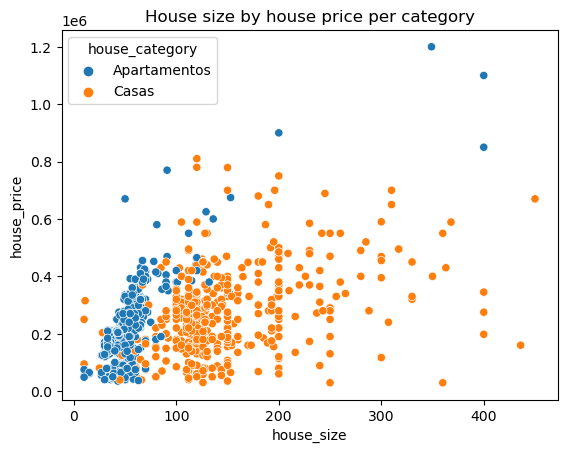

In [7]:
# Drop that specific blue point by defining these conditions
train_df = train_df\
            .drop(train_df[(train_df['house_size'] >= 500) & (train_df['house_price'] < 400000)].index)

# Check the points again
sns.scatterplot(
    data=train_df, 
    x = train_df['house_size'], 
    y = train_df['house_price'],
    hue=train_df['house_category'])

plt.title('House size by house price per category')
plt.show()

Note: As the reference notebook says, it's a delicate thing to just remove outliers. This is because we might delete important data and this might affect badly our models, as it might not be good at the test and the real data we could try to predict. So, instead of just removing all outliers, it's good practice to just deal with them and make robust models. Anyway, we just removed one outlier and we'll deal with the others left in this training dataset.

#### Target variable

house_price is the target variable we want to predict. Let's just take a look at it quickly:

/home/bombadil/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 234987.07 and sigma = 118337.05


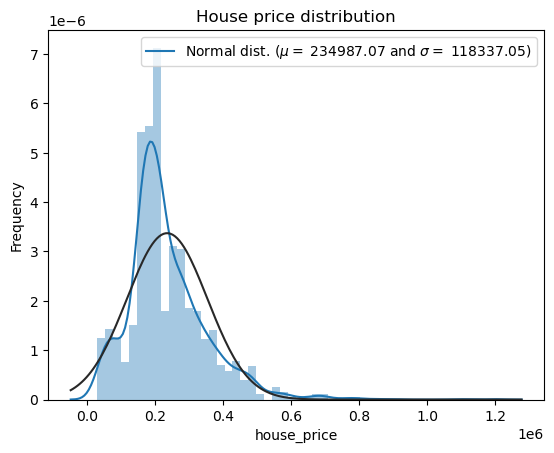

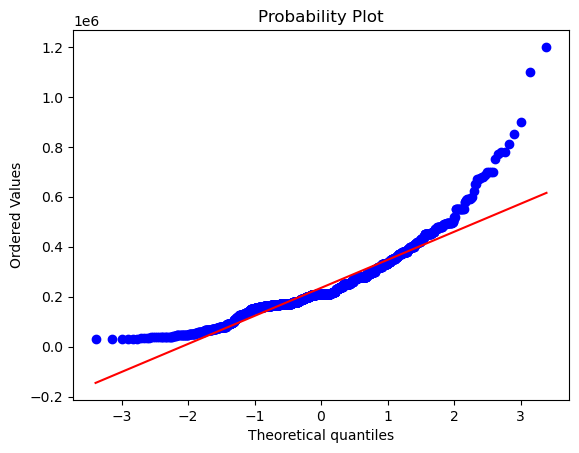

In [8]:
sns.distplot(train_df['house_price'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['house_price'])
print(f'\n mu = {mu:.2f} and sigma = {sigma:.2f}')

# plot the distribution
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f})'],
          loc = 'best')
plt.ylabel('Frequency')
plt.title('House price distribution')

# Plot also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['house_price'], plot=plt)
plt.show()

The house price variable is right skewed. We should make it more normal distributed as linear models expect this normal shape of the distribution.

#### Box-cox tranformation for house price variable



Best lambda = 0.36047667803076794

 mu = 230.03 and sigma = 42.35


/home/bombadil/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


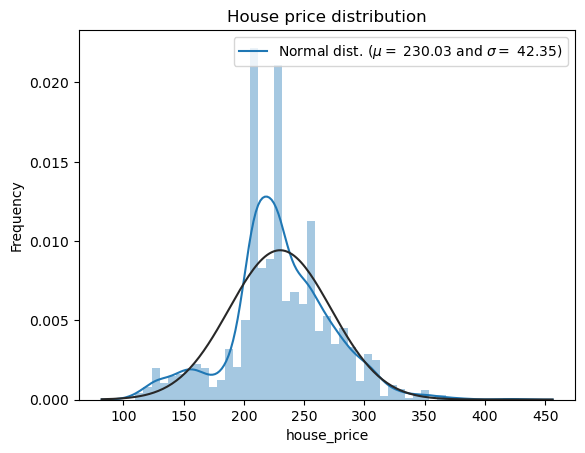

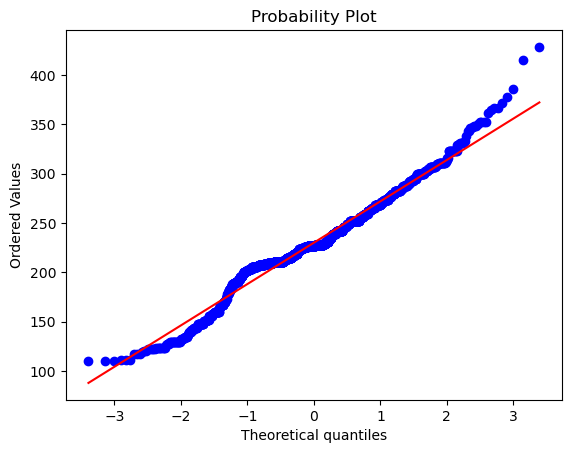

In [9]:
train_df['house_price'], best_lambda = stats.boxcox(x=train_df['house_price'])

print(f'Best lambda = {best_lambda}')
# check the new distribution

sns.distplot(train_df['house_price'], fit=norm)

# get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['house_price'])

print(f'\n mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f})'])
plt.ylabel('Frequency')
plt.title('House price distribution')

# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['house_price'], plot=plt)
plt.show()

It is not perfect but it looks better than before. We'll keep it that way. Now, our target variable is transformed. We saved the best lambda so we can use it to revert it back whenever needed.

### Feature Engineering

#### Missing data

Let's take a look at missing data:

In [10]:
train_df_na = (train_df.isnull().sum() / len(train_df)) * 100
train_df_na = train_df_na.drop(train_df_na[train_df_na == 0].index).sort_values(ascending=False)
missing_data_train = pd.DataFrame({'Missing Ratio train': train_df_na})
missing_data_train

,Missing Ratio train
street_address,16.650
n_bathrooms,15.392
house_category,14.738
zip_code,14.738
house_size,6.690


In [11]:
test_df_na = (test_df.isnull().sum() / len(test_df)) * 100
test_df_na = test_df_na.drop(test_df_na[test_df_na == 0].index).sort_values(ascending=False)
missing_data_test = pd.DataFrame({'Missing Ratio test': test_df_na})
missing_data_test

,Missing Ratio test
street_address,17.213
n_bathrooms,15.691
house_category,14.871
zip_code,14.871
house_size,6.206


We will fill the missing data by taking a look only at the train dataset. This is important to prevent any bias or data leakage. So, let's fill our train and test dataset:

The easiest one, fill <b>zip_code</b> and <b>street_address<b>:

In [12]:
# Fill zip code with None
train_df['zip_code'].fillna('None')
test_df['zip_code'].fillna('None')

# Fill street_address with None
train_df['street_address'].fillna('None')
test_df['street_address'].fillna('None')

print()

There is no way to fill zip_code and street_address features, so we will only fill it with "None".

Next, fill <b>house_category</b>:

['Apartamentos' 'Casas']
['Apartamentos' 'Casas']


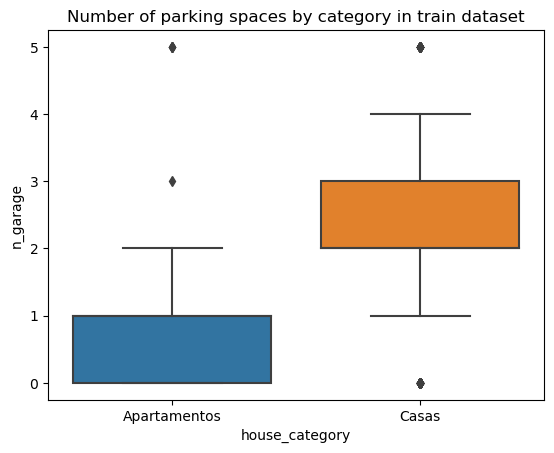

In [13]:
# Ploting number of car spaces by category
sns.boxplot(data=train_df, x='house_category', y='n_garage')
plt.title('Number of parking spaces by category in train dataset')

# FILLING MISSING DATA

# If house_category is None and has 2 or more parking spaces, then it's a house. Otherwise, it's an apartment
train_df.loc[(train_df.n_garage >= 2) & (train_df.house_category.isnull()),['house_category']] = 'Casas'
train_df.loc[(train_df.n_garage < 2) & (train_df.house_category.isnull()),['house_category']] = 'Apartamentos'

# If house_category is None and has 2 or more parking spaces, then it's a house. Otherwise, it's an apartment
test_df.loc[(test_df.n_garage >= 2) & (test_df.house_category.isnull()),['house_category']] = 'Casas'
test_df.loc[(test_df.n_garage < 2) & (test_df.house_category.isnull()),['house_category']] = 'Apartamentos'

# Checking unique categories:
print(train_df['house_category'].unique())
print(test_df['house_category'].unique())

Looking at the train dataset, we can see that houses have two or more parking spaces, in most cases, and apartments do not. So, I used this information to fill the category feature. If the property has two or more parking spaces, then it is a house, otherwise, it is an apartment.

Next, <b>house size</b>:

house_category
Apartamentos    54.032
Casas          155.006
Name: house_size, dtype: float64

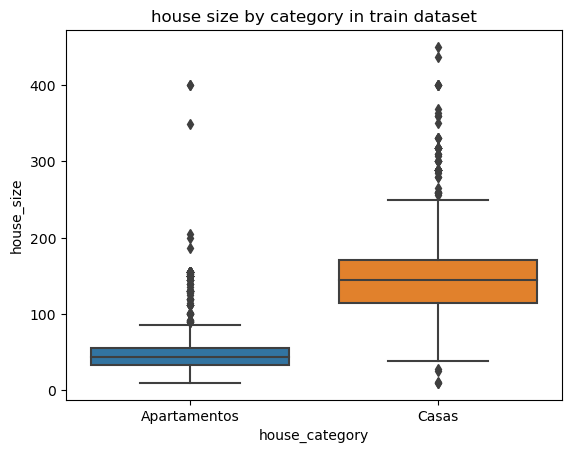

In [14]:
meansize_ap, meansize_houses = train_df.groupby('house_category')['house_size'].mean().values

# First, fillna with None
train_df['house_size'].fillna('None', inplace=True)
test_df['house_size'].fillna('None', inplace=True)

# Fill the train dataset with the mean by category
train_df.loc[(train_df.house_category == 'Casas') & (train_df.house_size == 'None'), ['house_size']]\
        = meansize_houses

train_df.loc[(train_df.house_category == 'Apartamentos') & (train_df.house_size == 'None'), ['house_size']]\
        = meansize_houses

# Fill the test dataset with the mean by category
test_df.loc[(test_df.house_category == 'Casas') & (test_df.house_size == 'None'), ['house_size']]\
        = meansize_houses

test_df.loc[(test_df.house_category == 'Apartamentos') & (test_df.house_size == 'None'), ['house_size']]\
        = meansize_houses

sns.boxplot(data=train_df, x = 'house_category', y = 'house_size')
plt.title('house size by category in train dataset')

train_df.groupby('house_category')['house_size'].mean()

Apartments, in average, have 54m² of size, houses have 155m². So, using category, we fill the missing sizing by the mean of the category size.

Now, n_bathrooms:

   n_bathrooms house_category  house_size
0            5   Apartamentos     113.500
1            5          Casas     220.433
2            0   Apartamentos      79.669
3            0          Casas     239.002
4            1   Apartamentos      45.553
5            1          Casas     135.733
6            2   Apartamentos      68.607
7            2          Casas     142.840
8            3   Apartamentos     116.600
9            3          Casas     175.671
10           4          Casas     203.887


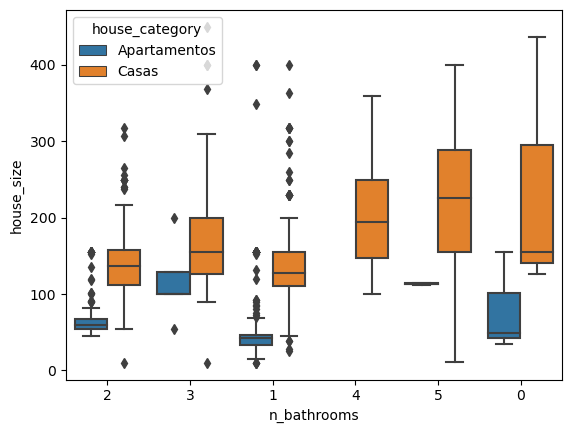

In [15]:
train_df['n_bathrooms'] = train_df['n_bathrooms'].apply(lambda x: 5 if x == '5 ou mais' else x)
test_df['n_bathrooms'] = test_df['n_bathrooms'].apply(lambda x: 5 if x == '5 ou mais' else x)

print(train_df.groupby(['n_bathrooms', 'house_category'])['house_size'].mean().reset_index())

sns.boxplot(data= train_df, x = 'n_bathrooms', y = 'house_size', hue = 'house_category')

# If it is a house, n_bath = 1
train_df.loc[(train_df['house_category'] == 'Casas') &\
              train_df['n_bathrooms'].isnull(),\
             ['n_bathrooms']] = '1'

# If it is an apartment, and it is 56m² or less, n_bath = 1
train_df.loc[(train_df['house_category'] == 'Apartamentos') &\
             (train_df['n_bathrooms'].isnull()) &\
             (train_df['house_size'] <= 56),\
             ['n_bathrooms']] = '1'

# If it is an apartment, and it is more than 56m² and less or equal to 92, n_bath = 2
train_df.loc[(train_df['house_category'] == 'Apartamentos') &\
             (train_df['n_bathrooms'].isnull()) &\
             (train_df['house_size'] > 56) &\
             (train_df['house_size'] <= 92),\
             ['n_bathrooms']] = '2'

# If it is an apartment, and it is more than 92, n_bath = 2
train_df.loc[(train_df['house_category'] == 'Apartamentos') &\
             (train_df['n_bathrooms'].isnull()) &\
             (train_df['house_size'] > 92),\
             ['n_bathrooms']] = '3'

# # # ---- Doing the same thing for test dataset

# If it is a house, n_bath = 1
test_df.loc[(test_df['house_category'] == 'Casas') &\
              test_df['n_bathrooms'].isnull(),\
             ['n_bathrooms']] = '1'

# If it is an apartment, and it is 56m² or less, n_bath = 1
test_df.loc[(test_df['house_category'] == 'Apartamentos') &\
             (test_df['n_bathrooms'].isnull()) &\
             (test_df['house_size'] <= 56),\
             ['n_bathrooms']] = '1'

# If it is an apartment, and it is more than 56m² and less or equal to 92, n_bath = 2
test_df.loc[(test_df['house_category'] == 'Apartamentos') &\
             (test_df['n_bathrooms'].isnull()) &\
             (test_df['house_size'] > 56) &\
             (test_df['house_size'] <= 92),\
             ['n_bathrooms']] = '2'

# If it is an apartment, and it is more than 92, n_bath = 2
test_df.loc[(test_df['house_category'] == 'Apartamentos') &\
             (test_df['n_bathrooms'].isnull()) &\
             (test_df['house_size'] > 92),\
             ['n_bathrooms']] = '3'

<AxesSubplot:xlabel='n_bathrooms', ylabel='house_size'>

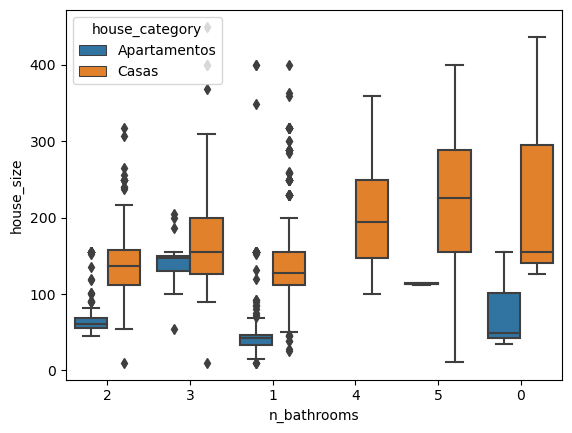

In [16]:
sns.boxplot(data= train_df, x = 'n_bathrooms', y = 'house_size', hue = 'house_category')

We can see that houses does not distinct too much in size, comparing it to the n_bathrooms. But apartments do!
So, apartments of mean size 45 have 1 bathroom, in most cases. Apartments of mean size 68 have 2 bathrooms. So, using that information, I filled with 1 bath if an apartment has size equal or less than 56 (because (68+45)/2=56), if it is greater than 56 then I filled with 2 bathrooms. For houses, I filled all of them with 1 bathroom.

In [17]:
train_df.isnull().sum()

house_price            0
house_region           0
n_bedrooms             0
has_condominium        0
value_condominium      0
has_garage             0
n_garage               0
house_size             0
house_category         0
n_bathrooms            0
zip_code             293
street_address       331
metro_distance         0
dtype: int64

In [18]:
test_df.isnull().sum()

house_price            0
house_region           0
n_bedrooms             0
has_condominium        0
value_condominium      0
has_garage             0
n_garage               0
house_size             0
house_category         0
n_bathrooms            0
zip_code             127
street_address       147
metro_distance         0
dtype: int64

#### More feature engineering

let's take a look again at the train dataset columns

In [19]:
train_df.head()

,house_price,house_region,n_bedrooms,has_condominium,value_condominium,has_garage,n_garage,house_size,house_category,n_bathrooms,zip_code,street_address,metro_distance
1649,269.354,Sul,2,Com condomínio,0.000,Com garagem,1,50.000,Apartamentos,2,72300533.000,Quadra 301 Conjunto 2,3
2761,297.457,Norte,3,Com condomínio,0.000,Com garagem,1,119.000,Apartamentos,2,72318210.000,QR 406 Conjunto 9-A,2
223,255.565,Norte,3,Com condomínio,385.000,Com garagem,1,155.006,Apartamentos,2,72318230.000,QR 406 Conjunto 28,2
106,227.189,Norte,3,Com condomínio,0.000,Com garagem,1,112.000,Casas,3,72322505.000,QS 602 Conjunto E Comércio,3
2541,216.059,Norte,2,Com condomínio,0.000,Com garagem,1,33.000,Apartamentos,1,72321000.000,QR 407,3


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 1649 to 219
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   house_price        1988 non-null   float64
 1   house_region       1988 non-null   object 
 2   n_bedrooms         1988 non-null   int64  
 3   has_condominium    1988 non-null   object 
 4   value_condominium  1988 non-null   float64
 5   has_garage         1988 non-null   object 
 6   n_garage           1988 non-null   int64  
 7   house_size         1988 non-null   object 
 8   house_category     1988 non-null   object 
 9   n_bathrooms        1988 non-null   object 
 10  zip_code           1695 non-null   float64
 11  street_address     1657 non-null   object 
 12  metro_distance     1988 non-null   int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 217.4+ KB


First, I'll transform the categorical columns into dummy variables:

In [21]:
# Get dummies for training dataset
train_df['is_north'] = pd.get_dummies(train_df['house_region'])['Norte']
train_df['condominium'] = pd.get_dummies(train_df['has_condominium'])['Com condomínio']
train_df['garage'] = pd.get_dummies(train_df['has_garage'])['Com garagem']
train_df['is_apartment'] = pd.get_dummies(train_df['house_category'])['Apartamentos']

# Get dummies for test dataset
test_df['is_north'] = pd.get_dummies(test_df['house_region'])['Norte']
test_df['condominium'] = pd.get_dummies(test_df['has_condominium'])['Com condomínio']
test_df['garage'] = pd.get_dummies(test_df['has_garage'])['Com garagem']
test_df['is_apartment'] = pd.get_dummies(test_df['house_category'])['Apartamentos']

train_df.head()

,house_price,house_region,n_bedrooms,has_condominium,value_condominium,has_garage,n_garage,house_size,house_category,n_bathrooms,zip_code,street_address,metro_distance,is_north,condominium,garage,is_apartment
1649,269.354,Sul,2,Com condomínio,0.000,Com garagem,1,50.000,Apartamentos,2,72300533.000,Quadra 301 Conjunto 2,3,0,1,1,1
2761,297.457,Norte,3,Com condomínio,0.000,Com garagem,1,119.000,Apartamentos,2,72318210.000,QR 406 Conjunto 9-A,2,1,1,1,1
223,255.565,Norte,3,Com condomínio,385.000,Com garagem,1,155.006,Apartamentos,2,72318230.000,QR 406 Conjunto 28,2,1,1,1,1
106,227.189,Norte,3,Com condomínio,0.000,Com garagem,1,112.000,Casas,3,72322505.000,QS 602 Conjunto E Comércio,3,1,1,1,0
2541,216.059,Norte,2,Com condomínio,0.000,Com garagem,1,33.000,Apartamentos,1,72321000.000,QR 407,3,1,1,1,1


It is perfect! Now, I will make a new column and name it 'is_pair'. Samambaia houses block address might be pair or not pair, and that information is given by the street_address feature. So, that's what I will do:

<AxesSubplot:xlabel='house_region', ylabel='count'>

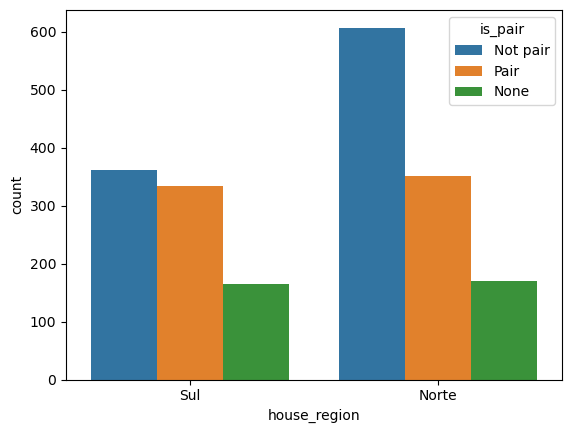

In [22]:
def get_num_block(street_address):
    
    try:
        number_block = street_address.split()[1]
        
        try:
            number_block = int(number_block)
            return number_block
        except:
            return 'None'
    except:
        return 'None'
    
def get_ispar_block(num_block):
    
    try:
        num_block = int(num_block)
        
        if num_block % 2 == 0:
            return 'Pair'
        else:
            return 'Not pair'
    except:
        return 'None'
    
# Get the information whether a block is pair or not for train dataset
train_df['num_block'] = train_df['street_address'].apply(get_num_block)
train_df['is_pair'] = train_df['num_block'].apply(get_ispar_block)

# Get the information whether a block is pair or not for test dataset
test_df['num_block'] = test_df['street_address'].apply(get_num_block)
test_df['is_pair'] = test_df['num_block'].apply(get_ispar_block)

sns.countplot(x ='house_region', hue = "is_pair", data = train_df)

The None category means we do not know if it is a pair or not pair block number, so for now I'll leave it that way. We have zip_code column to extract that information, but, by now, I don't know how to do it so, that's it!

Finally, get the dummy variables of is_pair column:

In [23]:
pd.get_dummies(train_df['is_pair'])

,None,Not pair,Pair
1649,0,1,0
2761,0,0,1
223,0,0,1
106,0,0,1
2541,0,1,0
...,...,...,...
1638,0,0,1
1774,0,0,1
1880,0,1,0
2369,0,1,0


In [24]:
# Get dummy variables for train dataset
train_df['pair'] = pd.get_dummies(train_df['is_pair'])['Pair']
train_df['not_pair'] = pd.get_dummies(train_df['is_pair'])['Not pair']

# Get dummy variables for test dataset
test_df['pair'] = pd.get_dummies(test_df['is_pair'])['Pair']
test_df['not_pair'] = pd.get_dummies(test_df['is_pair'])['Not pair']

train_df.head()

,house_price,house_region,n_bedrooms,has_condominium,value_condominium,has_garage,n_garage,house_size,house_category,n_bathrooms,...,street_address,metro_distance,is_north,condominium,garage,is_apartment,num_block,is_pair,pair,not_pair
1649,269.354,Sul,2,Com condomínio,0.000,Com garagem,1,50.000,Apartamentos,2,...,Quadra 301 Conjunto 2,3,0,1,1,1,301,Not pair,0,1
2761,297.457,Norte,3,Com condomínio,0.000,Com garagem,1,119.000,Apartamentos,2,...,QR 406 Conjunto 9-A,2,1,1,1,1,406,Pair,1,0
223,255.565,Norte,3,Com condomínio,385.000,Com garagem,1,155.006,Apartamentos,2,...,QR 406 Conjunto 28,2,1,1,1,1,406,Pair,1,0
106,227.189,Norte,3,Com condomínio,0.000,Com garagem,1,112.000,Casas,3,...,QS 602 Conjunto E Comércio,3,1,1,1,0,602,Pair,1,0
2541,216.059,Norte,2,Com condomínio,0.000,Com garagem,1,33.000,Apartamentos,1,...,QR 407,3,1,1,1,1,407,Not pair,0,1


Now, selecting all the columns we need and removing those we don't, we have:

In [25]:
cols = ['house_price', 'n_bedrooms', 'value_condominium', 'n_garage', 'house_size',
            'n_bathrooms', 'metro_distance', 'is_north', 'condominium', 'garage',
            'is_apartment', 'num_block', 'pair', 'not_pair']
train_df[cols].head()

,house_price,n_bedrooms,value_condominium,n_garage,house_size,n_bathrooms,metro_distance,is_north,condominium,garage,is_apartment,num_block,pair,not_pair
1649,269.354,2,0.000,1,50.000,2,3,0,1,1,1,301,0,1
2761,297.457,3,0.000,1,119.000,2,2,1,1,1,1,406,1,0
223,255.565,3,385.000,1,155.006,2,2,1,1,1,1,406,1,0
106,227.189,3,0.000,1,112.000,3,3,1,1,1,0,602,1,0
2541,216.059,2,0.000,1,33.000,1,3,1,1,1,1,407,0,1


In [26]:
numeric_feats = train_df.iloc[:, 1:].dtypes[train_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
value_condominium,27.046
zip_code,9.046
n_bedrooms,1.252
n_garage,0.990
pair,0.656
not_pair,0.050
is_north,-0.272
is_apartment,-0.396
garage,-1.311
condominium,-1.762


In [27]:
skewness = skewness[abs(skewness) > 1]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    train_df[feat] = boxcox1p(train_df[feat], lam)

There are 11 skewed numerical features to Box Cox transform


In [28]:
train_df.head()

,house_price,house_region,n_bedrooms,has_condominium,value_condominium,has_garage,n_garage,house_size,house_category,n_bathrooms,...,street_address,metro_distance,is_north,condominium,garage,is_apartment,num_block,is_pair,pair,not_pair
1649,269.354,Sul,1.194,Com condomínio,0.000,Com garagem,0.730,50.000,Apartamentos,2,...,Quadra 301 Conjunto 2,1.541,0.000,0.730,0.730,0.730,301,Not pair,0.000,0.730
2761,297.457,Norte,1.541,Com condomínio,0.000,Com garagem,0.730,119.000,Apartamentos,2,...,QR 406 Conjunto 9-A,1.194,0.730,0.730,0.730,0.730,406,Pair,0.730,0.000
223,255.565,Norte,1.541,Com condomínio,9.622,Com garagem,0.730,155.006,Apartamentos,2,...,QR 406 Conjunto 28,1.194,0.730,0.730,0.730,0.730,406,Pair,0.730,0.000
106,227.189,Norte,1.541,Com condomínio,0.000,Com garagem,0.730,112.000,Casas,3,...,QS 602 Conjunto E Comércio,1.541,0.730,0.730,0.730,0.000,602,Pair,0.730,0.000
2541,216.059,Norte,1.194,Com condomínio,0.000,Com garagem,0.730,33.000,Apartamentos,1,...,QR 407,1.541,0.730,0.730,0.730,0.730,407,Not pair,0.000,0.730


## Modeling

In [35]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.5 MB/s eta 0:00:0031m9.3 MB/s eta 0:00:01
